In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
import time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,\
    precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import time
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
games = pd.read_csv('data/full_data.csv',index_col=0)

In [3]:
games['home_cover'] = np.where((games['home_fav']) & ((games['home_pts'] + games['PointSpread']) > games['away_pts']),1,
                              np.where((games['home_fav'] == False) & ((games['away_pts'] + games['PointSpread']) < games['home_pts']),1,0))
                              #logic to identify pushes. Very few, will treat as a non-home cover
                              #np.where((games['home_fav']) & (games['home_pts'] + games['PointSpread']) == games['away_pts'],"push",
                              #np.where((games['home_fav']==False) & ((games['away_pts'] + games['PointSpread']) == games['home_pts']),"push",0))))

In [4]:
#discard 6 games with no daily fantasy salaries
games[games.isna().any(axis=1)]

,season,Week,home_pts,away_pts,total_pts,home_win,Day,Time,home_abbr,away_abbr,PointSpread,OverUnder,AwayTeamMoneyLine,HomeTeamMoneyLine,home_fav,date_match,DST1_away,DST1_home,QB1_away,QB1_home,RB1_away,RB1_home,RB2_away,RB2_home,WR1_away,WR1_home,WR2_away,WR2_home,WR3_away,WR3_home,WR4_away,WR4_home,TE1_away,TE1_home,TE2_away,TE2_home,home_cover
139,2016,10,24.0,15.0,39.0,1,Sun,1:00PM,PHI,ATL,-1.0,49.0,106,-125,True,2016-11-13,2600.0,2600.0,7300.0,5400.0,6800.0,4300.0,4900.0,3700.0,9500.0,3100.0,4600.0,3000.0,3400.0,3000.0,3000.0,NaN,3100.0,5900.0,2800.0,3700.0,1
158,2016,11,26.0,15.0,41.0,1,Sun,4:25PM,SEA,PHI,-6.5,43.0,235,-275,True,2016-11-20,2500.0,3800.0,5000.0,6100.0,4500.0,4300.0,4200.0,4200.0,3000.0,5700.0,3000.0,3600.0,3000.0,3000.0,NaN,3000.0,5400.0,5600.0,3200.0,2500.0,1
176,2016,12,13.0,27.0,40.0,0,Mon,8:30PM,PHI,GB,-4.0,47.0,170,-200,True,2016-11-28,2800.0,3000.0,7000.0,5400.0,4400.0,4500.0,3300.0,4300.0,7400.0,3000.0,6600.0,3000.0,5700.0,3000.0,4700.0,NaN,2600.0,5000.0,2500.0,3700.0,0
333,2017,6,23.0,28.0,51.0,0,Thu,8:25PM,CAR,PHI,-3.0,44.0,135,-145,True,2017-10-12,3200.0,3000.0,6600.0,6700.0,4700.0,5900.0,4700.0,4000.0,6300.0,6400.0,4200.0,3800.0,3800.0,3700.0,3000.0,NaN,6300.0,6100.0,2500.0,4600.0,0
547,2018,3,31.0,21.0,52.0,1,Sun,1:00PM,CAR,CIN,-3.0,44.0,133,-143,True,2018-09-23,2500.0,2700.0,5700.0,6000.0,6300.0,7800.0,5900.0,3700.0,7500.0,3800.0,3700.0,3700.0,3500.0,3500.0,3000.0,NaN,3200.0,5000.0,2600.0,5000.0,1
606,2018,7,20.0,19.0,39.0,1,Sun,9:30AM,LAC,TEN,-6.5,46.0,248,-270,True,2018-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
767,2018,17,17.0,33.0,50.0,0,Sun,8:20PM,TEN,IND,-5.5,42.5,-235,215,False,2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
825,2019,4,10.0,27.0,37.0,0,Sun,4:05PM,ARI,SEA,-5.0,48.0,-244,196,False,2019-09-29,3300.0,2400.0,6100.0,6000.0,5700.0,6800.0,4200.0,3600.0,6300.0,5600.0,4800.0,5100.0,3700.0,3400.0,3400.0,3300.0,3600.0,2600.0,NaN,2600.0,0
1023,2019,17,21.0,26.0,47.0,0,Sun,8:20PM,SEA,SF,-3.0,47.0,-186,155,False,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1085,2020,4,26.0,10.0,36.0,1,Mon,7:05PM,KC,NE,-11.0,48.5,468,-621,True,2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
games[['home_fav','PointSpread','home_pts','away_pts','home_cover']].sample(n = 5)

,home_fav,PointSpread,home_pts,away_pts,home_cover
884,True,-4.0,51.0,13.0,1
1251,False,-1.5,25.0,26.0,1
711,False,-9.0,14.0,28.0,0
442,True,-13.0,19.0,10.0,0
750,False,-1.0,38.0,31.0,1


In [6]:
#create aggregations of offensive salaries for home, away, and total
away_offense = ['QB1_away','RB1_away','RB2_away', 'WR1_away', 'WR2_away','WR3_away', 'WR4_away', 'TE1_away','TE2_away']
home_offense = ['QB1_home','RB1_home', 'RB2_home', 'WR1_home','WR2_home', 'WR3_home', 'WR4_home','TE1_home', 'TE2_home']
games['away_off_total'] = games.filter(away_offense).sum(axis = 1)
games['home_off_total'] = games.filter(away_offense).sum(axis = 1)
games['total_offense_sal'] = games['away_off_total'] + games['home_off_total']

In [7]:
games_2022 = games.loc[(games['season'] == 2022) & (games['Week'] != 13)]
games_dev = games.loc[games['season'] != 2022]
games_dev.dropna(subset=['QB1_home'], axis = 0, inplace = True)

C:\Users\binga\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
pred_cols = ['DST1_away', 'DST1_home', 'QB1_away', 'QB1_home', 'RB1_away',
       'RB1_home', 'RB2_away', 'RB2_home', 'WR1_away', 'WR1_home', 'WR2_away',
       'WR2_home', 'WR3_away', 'WR3_home', 'WR4_away', 'WR4_home', 'TE1_away',
       'TE1_home', 'TE2_away', 'TE2_home','away_off_total','home_off_total','total_offense_sal',
        'AwayTeamMoneyLine','HomeTeamMoneyLine','OverUnder','PointSpread','home_fav']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(games_dev.filter(pred_cols).fillna(0),games_dev['home_cover'], test_size=0.25, random_state=44)

In [10]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
random_state = 44

In [12]:
def plot_and_get_metrics(clf):
    preds_pp = cross_val_predict(clf, x_train, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

In [13]:
def plot_and_get_metrics_scaled(clf):
    preds_pp = cross_val_predict(clf, x_train_scaled, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

### KNN 

In [14]:
knn = KNeighborsClassifier()
start_time = time.time()
param_grid = {
    'n_neighbors' : [num for num in range(2,34)],
    'weights' : ['uniform','distance'],
    'p': [1,2],
    'n_jobs': [-1]
}

knn_grid = GridSearchCV(knn, param_grid, scoring='balanced_accuracy', n_jobs=-1)
knn_grid.fit(x_train, y_train)
best_knn = knn_grid.best_estimator_
print(time.time() - start_time)
best_knn

7.1219024658203125


KNeighborsClassifier(n_jobs=-1, n_neighbors=33)

              precision    recall  f1-score   support

           0       0.53      0.60      0.56       620
           1       0.46      0.40      0.43       539

    accuracy                           0.50      1159
   macro avg       0.50      0.50      0.49      1159
weighted avg       0.50      0.50      0.50      1159



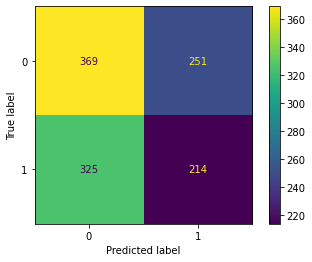

In [15]:
knn_run = KNeighborsClassifier(n_neighbors = 21, weights = 'distance')
best_knn = knn_run.fit(x_train,y_train)
knn_preds_pp, knn_preds, knn_cv_acc, knn_cv_prec, knn_cv_recall, knn_cv_auc = plot_and_get_metrics(best_knn)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.55      0.72      0.62       620
           1       0.50      0.31      0.38       539

    accuracy                           0.53      1159
   macro avg       0.52      0.52      0.50      1159
weighted avg       0.52      0.53      0.51      1159



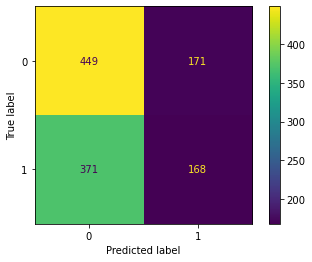

In [16]:
run_nb = GaussianNB()
run_nb.fit(x_train,y_train)
best_nb = run_nb
nb_preds_pp, nb_preds, nb_cv_acc, nb_cv_prec, nb_cv_recall, nb_cv_auc = plot_and_get_metrics(run_nb)

### SVM

In [17]:
svm = SVC(probability = True, random_state = random_state, max_iter = 2000)
start_time = time.time()
param_grid = {
    'C' : [1,1.2,1.3,1.5,1.65,1.8,2],
    'kernel' : ['poly','rbf','linear'],
    'degree': [2,3],
}

svm_grid = GridSearchCV(svm, param_grid, scoring='balanced_accuracy', n_jobs=-1)
svm_grid.fit(x_train_scaled, y_train)
best_svm = svm_grid.best_estimator_
print(time.time() - start_time)
best_svm

15.004384756088257


C:\Users\binga\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=1.5, degree=2, kernel='poly', max_iter=2000, probability=True,
    random_state=44)

              precision    recall  f1-score   support

           0       0.54      0.98      0.69       620
           1       0.55      0.03      0.06       539

    accuracy                           0.54      1159
   macro avg       0.54      0.50      0.38      1159
weighted avg       0.54      0.54      0.40      1159



C:\Users\binga\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


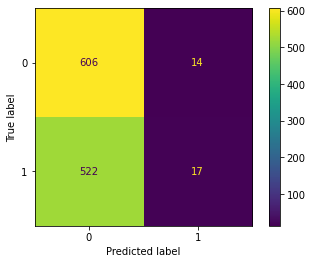

In [18]:
run_svm = SVC(C=1.5, kernel='poly', max_iter=50, probability=True, random_state=44)
svm_preds_pp, svm_preds, svm_cv_acc, svm_cv_prec, svm_cv_recall, svm_cv_auc = plot_and_get_metrics_scaled(best_svm)

def compare(true_vals, preds_pp, preds, model, vegas=True):
    if vegas:
        compar_df = x_train.copy()
        compar_df['vegas'] = compar_df.apply(lambda row: 1 if row['home_Close_line']<0 else 0, axis=1)
        df = pd.DataFrame({'true': true_vals,'{}_probs'.format(model): preds_pp,'{}_predicted'.format(model): preds, 'vegas': compar_df['vegas']})
        df['correct?'] = df.apply(lambda row: 'correct' if row['true'] == row[2] else 'incorrect', axis=1)
        df['match_vegas?'] = df.apply(lambda row: 'match_veg' if row[2] == row['vegas'] else 'different', axis=1)
        print(df[['match_vegas?','correct?']].value_counts())
        sns.displot(data=df, x='{}_probs'.format(model), hue='correct?', kind="kde", col='true')
        plt.show()
    else:
        df = pd.DataFrame({'true': true_vals,'{}_probs'.format(model): preds_pp,'{}_predicted'.format(model): preds})
        df['correct?'] = df.apply(lambda row: 'correct' if row['true'] == row[2] else 'incorrect', axis=1)
        sns.displot(data=df, x='{}_probs'.format(model), hue='correct?', kind="kde", col='true')
        plt.show()

### Random Forest

In [19]:
start_time = time.time()
rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
param_grid = {
    'n_estimators': [150,200,250],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [x for x in range(2,7)],
    'max_depth': [5,10,15,20],
    'bootstrap': [True]
}
rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', n_jobs=-1)
rf_clf.fit(x_train, y_train)
best_rf = rf_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_rf

1.77


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=6,
                       n_estimators=150, random_state=44)

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       620
           1       0.49      0.44      0.46       539

    accuracy                           0.53      1159
   macro avg       0.53      0.52      0.52      1159
weighted avg       0.53      0.53      0.53      1159



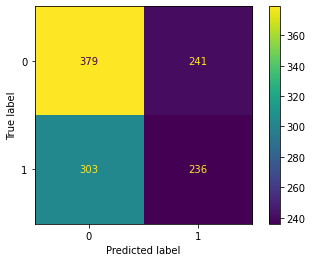

In [20]:
rf_run = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_leaf=2, n_estimators=250,
                       random_state=44)
rf_preds_pp, rf_preds, rf_cv_acc, rf_cv_prec, rf_cv_recall, rf_cv_auc = plot_and_get_metrics(best_rf)

### Light GBM

In [21]:
start_time = time.time()
lgbmc = lgb.LGBMClassifier(class_weight='balanced', random_state=random_state)

param_grid = {
    'max_depth': [5,10,15,20],
    # 'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01, 0.025],
    'n_estimators': [150, 200, 250],
    # 'feature_fraction': [0.5],
    'min_child_samples': [x for x in range(2,5)],
    'reg_alpha': [0.1, 0.5,1,1.5],
    'reg_lambda': [0.1, 0.5,1,1.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring='accuracy',
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

lgbmc_clf.fit(x_train, y_train)
best_lgb = lgbmc_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_lgb

11.67


LGBMClassifier(class_weight='balanced', learning_rate=0.025, max_depth=10,
               min_child_samples=4, n_estimators=250, random_state=44,
               reg_alpha=0.1, reg_lambda=0.1)

In [22]:
lgbm_run = lgb.LGBMClassifier(class_weight='balanced', learning_rate=0.025, max_depth=10,
               min_child_samples=4, n_estimators=250, random_state=44,
               reg_alpha=0.1, reg_lambda=0.5)
best_lgb = lgbm_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       620
           1       0.47      0.45      0.46       539

    accuracy                           0.51      1159
   macro avg       0.50      0.50      0.50      1159
weighted avg       0.50      0.51      0.51      1159



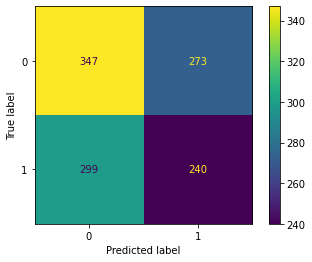

In [23]:
lgb_preds_pp, lgb_preds, lgb_cv_acc, lgb_cv_prec, lgb_cv_recall, lgb_cv_auc = plot_and_get_metrics(best_lgb)

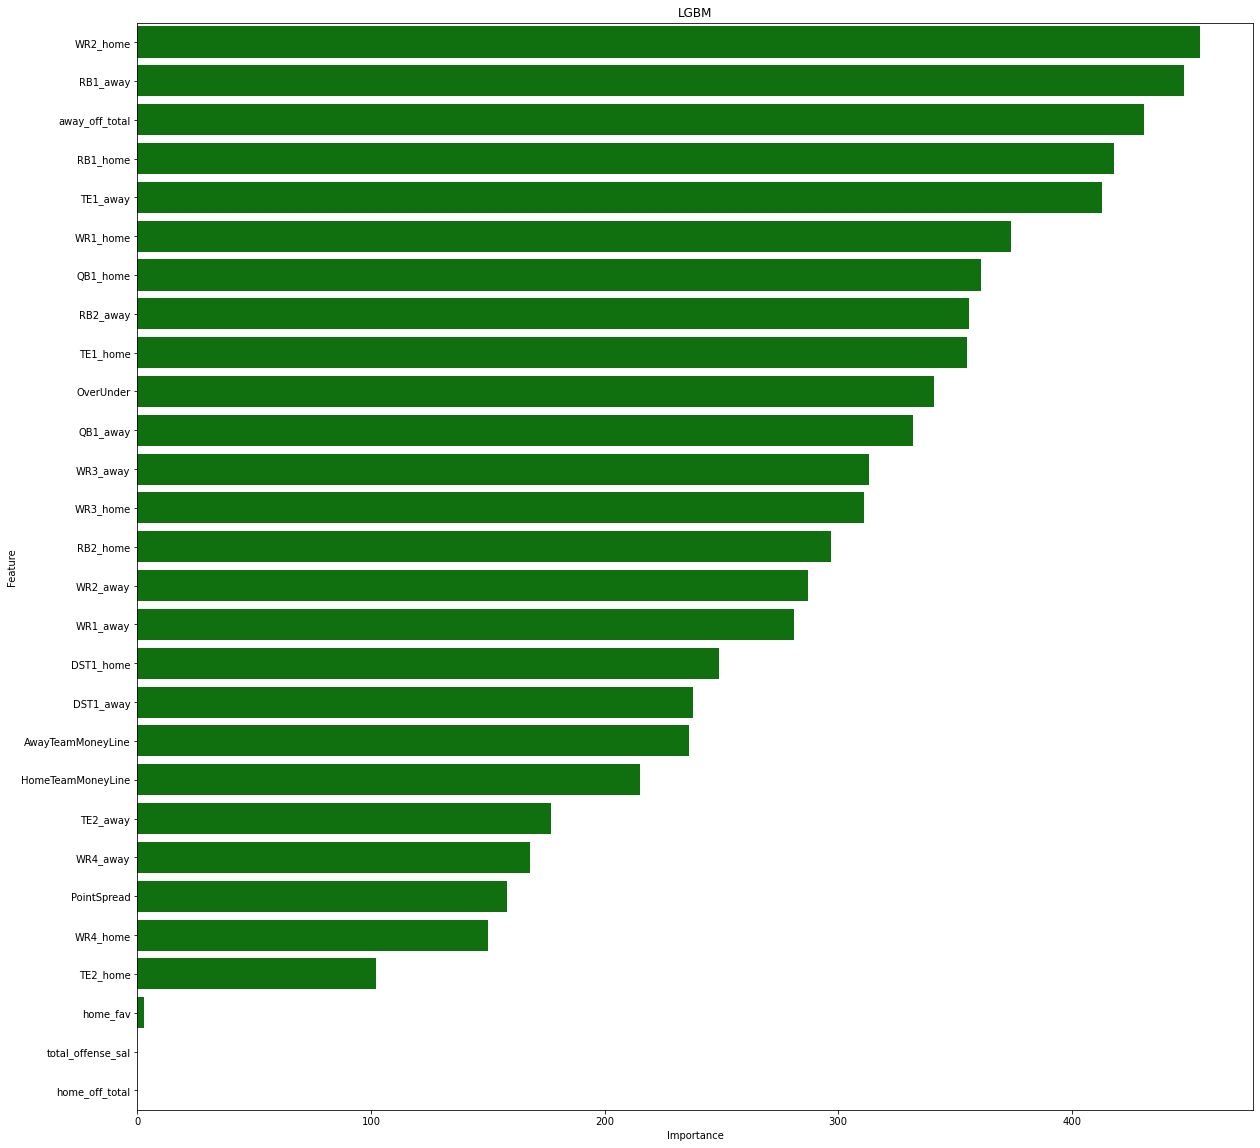

In [26]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_lgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('LGBM')
plt.savefig('feat_import_LGBM.png')

### XGBoost

In [27]:
import warnings
warnings.filterwarnings("ignore")
xgb = XGBClassifier(scale_pos_weight=4, random_state=random_state)
start_time = time.time()
param_grid = {
    'n_estimators': [150,250,300],
    'learning_rate': [0.05,0.1],
    'max_depth': [20,25],
    'subsample': [0.5, 0.75],
    'alpha': [0.1,1,1.5],
    'lambda': [0.5,1,5]
}


xgb_clf = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1)

xgb_clf.fit(x_train, y_train)
best_xgb = xgb_clf.best_estimator_
print((time.time() - start_time)/60)
best_xgb

[22:36:27] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9.77544910510381


XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=0.5, learning_rate=0.1,
              max_delta_step=0, max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0.100000001, reg_lambda=0.5, scale_pos_weight=4,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [28]:
xgb_run = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=20,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=44, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)
best_xgb = xgb_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.53      0.32      0.40       620
           1       0.46      0.67      0.55       539

    accuracy                           0.48      1159
   macro avg       0.49      0.49      0.47      1159
weighted avg       0.50      0.48      0.47      1159



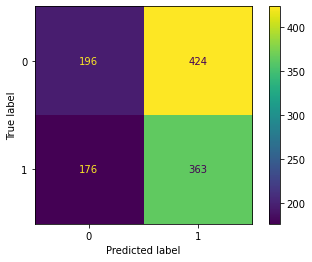

In [29]:
xgb_preds_pp, xgb_preds, xgb_cv_acc, xgb_cv_prec, xgb_cv_recall, xgb_cv_auc = plot_and_get_metrics(best_xgb)

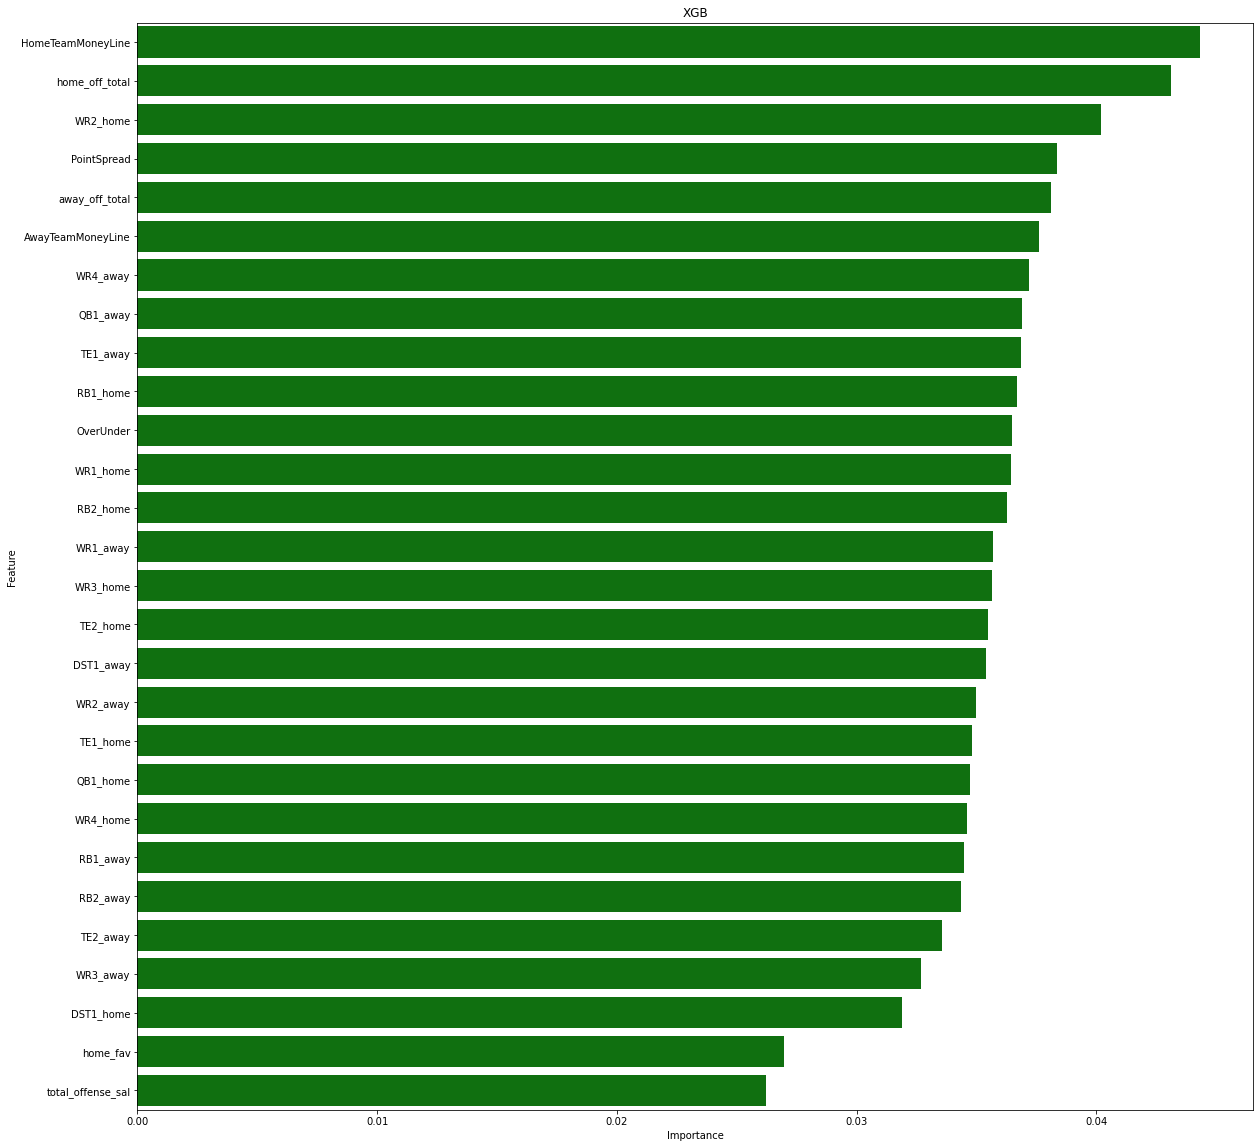

In [30]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_xgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('XGB')
plt.savefig('feat_import_xgb.png')

In [31]:
model_names = ['XGB', 'LGBM', 'RF',  'KNN', 'SVM','NB']
cv_accuracy = pd.Series([xgb_cv_acc, lgb_cv_acc, rf_cv_acc, knn_cv_acc, svm_cv_acc, nb_cv_acc], name='Accuracy')
cv_recall = pd.Series([xgb_cv_recall, lgb_cv_recall, rf_cv_recall, knn_cv_recall, svm_cv_recall, nb_cv_recall], name='Recall')
cv_precision = pd.Series([xgb_cv_prec, lgb_cv_prec, rf_cv_prec, knn_cv_prec, svm_cv_prec, nb_cv_prec],name='Precision')
cv_auc = pd.Series([xgb_cv_auc, lgb_cv_auc, rf_cv_auc,  knn_cv_auc, svm_cv_auc, nb_cv_auc], name='AUC')

In [47]:
scores_summary = pd.concat([cv_accuracy, cv_recall, cv_precision, cv_auc], axis=1)
scores_summary.columns = ['Accuracy', 'Recall', 'Precision', 'AUC']
scores_summary.index = model_names
scores_summary.style.highlight_max(color='green', axis=0)

,Accuracy,Recall,Precision,AUC
XGB,0.482312,0.673469,0.461245,0.494799
LGBM,0.506471,0.445269,0.467836,0.502473
RF,0.530630,0.437848,0.494759,0.524569
KNN,0.503020,0.397032,0.460215,0.496096
SVM,0.537532,0.031540,0.548387,0.504480
NB,0.532355,0.311688,0.495575,0.517941


In [33]:
comp_df = pd.DataFrame({'true': y_train, 'knn_preds_pp': knn_preds_pp, 'rf_preds_pp': rf_preds_pp,\
                        'lgb_preds_pp':lgb_preds_pp,'xgb_preds_pp':xgb_preds_pp ,'nb_preds_pp':nb_preds_pp,\
                        'svm_preds_pp': svm_preds_pp})
comp_df.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp
1524,0,0.418239,0.474163,0.258259,0.511869,0.360014,0.465792
218,1,0.483582,0.539980,0.702796,0.698448,0.955200,0.440760
1039,1,0.460411,0.511830,0.598735,0.862406,0.187927,0.467192
1229,0,0.333520,0.479789,0.286048,0.352185,0.276661,0.479970
61,1,0.481259,0.517419,0.543810,0.622198,0.360147,0.452369


Only bet when our model probability is higher than Vegas' implied probability. If both higher than Vegas, take the one with higher margin.

In [34]:
def away_return(df):
    if (df['bet_away'] and (df['true'] == 1)):
        return -100
    elif (df['bet_away'] & (df['true'] == 0)):
        #standard offer odds of -110 on the bet
        return round((100/-110)*-100,2)
    else: 
        return 0
    
def home_return(df):
    if (df['bet_home'] and (df['true'] == 0)):
        return -100
    elif (df['bet_home'] & (df['true'] == 1)):
        return round((100/-110)*-100,2)
    else: 
        return 0
def pred_vs_vegas(model_preds, comp, margin = 0):
    '''
    
    :param margin: margin between our predictions and vegas predictions to trigger making a bet (example: 0.05)
    :param comp: comparison dataframe to use for function (train or test predictions)
    :param model_preds: model column name of prediction probability
    :return:% return, $ risked, total $ returned
    '''
    #create working dataframe
    df_w = comp[['true',model_preds]]
    
    #calculate differential of our predictions vs standard -110 offer (translates to 52.38% probability)
    df_w['home_cov_adv'] = df_w[model_preds] - 0.5238
    df_w['away_cov_adv'] = (1-df_w[model_preds]) - 0.5238
    
    #flag whether the home differential is higher than the away differential
    df_w['home_cov_higher'] = df_w['home_cov_adv'] > df_w['away_cov_adv']
    
    #flag whether to bet on the home or away team
    df_w['bet_home'] = np.where((df_w['home_cov_higher'] & (df_w['home_cov_adv']>margin)), True, False)
    df_w['bet_away'] = np.where(((df_w['bet_home'] == False) & (df_w['away_cov_adv']>margin)), True, False)
    
    #generate bet returns
    df_w['home_risk'] = np.where(df_w['bet_home'], 100, 0)
    df_w['away_risk'] = np.where(df_w['bet_away'], 100, 0)
    df_w['away_return'] = df_w.apply(away_return, axis = 1)
    df_w['home_return'] = df_w.apply(home_return, axis = 1)
    
    #aggregate risks and returns
    df_w['risk'] = df_w['home_risk'] + df_w['away_risk']
    df_w['return'] = df_w['away_return'] + df_w['home_return']
    
    return df_w

def aggregate_returns(df_w):
    return df_w['risk'].sum(),df_w['return'].sum(),(df_w['return'].sum()/df_w['risk'].sum())

In [35]:
final_models = ['knn_preds_pp','svm_preds_pp','nb_preds_pp','rf_preds_pp','xgb_preds_pp','lgb_preds_pp']

In [36]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

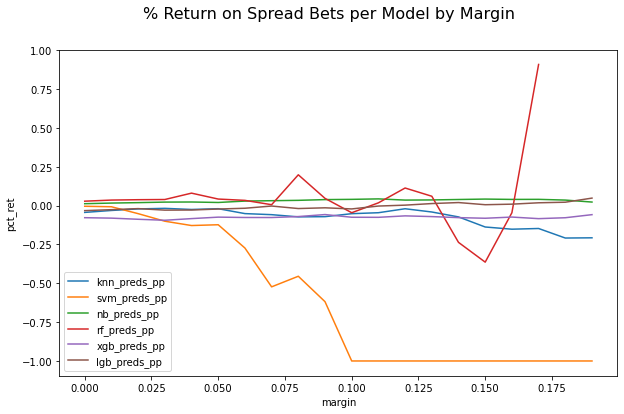

In [37]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df)
plt.suptitle('% Return on Spread Bets per Model by Margin', size=16)
plt.legend(loc='lower left')
plt.savefig('strat_3_ret.png')

In [45]:
higher_exp_val_df.loc[higher_exp_val_df['model'] == 'nb_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
40,nb_preds_pp,0.00,0.012608,111800,1409.63
41,nb_preds_pp,0.01,0.016691,110600,1845.99
42,nb_preds_pp,0.02,0.019473,108800,2118.71
43,nb_preds_pp,0.03,0.022922,107500,2464.16
44,nb_preds_pp,0.04,0.023564,106500,2509.61
45,nb_preds_pp,0.05,0.020507,104200,2136.87
46,nb_preds_pp,0.06,0.029564,101800,3009.59
47,nb_preds_pp,0.07,0.031946,99900,3191.40
48,nb_preds_pp,0.08,0.034258,98200,3364.12
49,nb_preds_pp,0.09,0.038980,96100,3745.93


In [39]:
comp_df2 = pd.DataFrame({'true': games_2022['home_cover'], 'knn_preds_pp': best_knn.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'rf_preds_pp': best_rf.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'lgb_preds_pp':best_lgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'xgb_preds_pp':best_xgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'nb_preds_pp':best_nb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'svm_preds_pp':best_svm.predict_proba(scaler.transform(games_2022.filter(pred_cols).fillna(0)))[:,1]})
comp_df2.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp
1552,0,0.360248,0.519550,0.656547,0.718203,0.926469,0.464912
1553,1,0.335502,0.501736,0.640561,0.503543,0.939225,0.464527
1554,0,0.567414,0.465461,0.246449,0.273795,0.119486,0.461099
1555,1,0.537670,0.469943,0.531736,0.613791,0.272822,0.464315
1556,0,0.565761,0.513330,0.557561,0.821955,0.137023,0.465308


In [40]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df2,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df2 = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

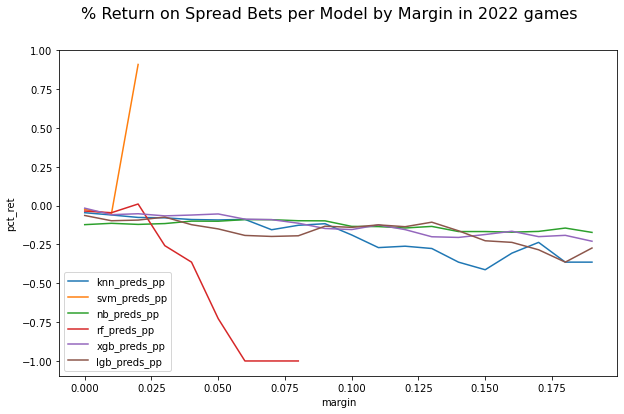

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df2)
plt.suptitle('% Return on Spread Bets per Model by Margin in 2022 games', size=16)
plt.legend(loc='lower left')
plt.savefig('strat_3_ret.png')

In [46]:
higher_exp_val_df2.loc[higher_exp_val_df2['model'] == 'nb_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
40,nb_preds_pp,0.00,-0.122253,17400,-2127.20
41,nb_preds_pp,0.01,-0.113632,16800,-1909.02
42,nb_preds_pp,0.02,-0.120657,16500,-1990.84
43,nb_preds_pp,0.03,-0.115295,16400,-1890.84
44,nb_preds_pp,0.04,-0.099481,15900,-1581.75
45,nb_preds_pp,0.05,-0.100169,15700,-1572.66
46,nb_preds_pp,0.06,-0.089701,15100,-1354.48
47,nb_preds_pp,0.07,-0.090295,14900,-1345.39
48,nb_preds_pp,0.08,-0.097047,14800,-1436.30
49,nb_preds_pp,0.09,-0.097754,14600,-1427.21
